<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 0
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 1.7685561  -1.0123726  -1.2162024  -0.8043785  -0.95765865]
 [-0.2686218  -0.17254224  0.18338789 -1.0724636   0.21355206]
 [ 0.20479238 -1.1025096  -0.5249605   0.83721536 -1.6372701 ]
 [ 0.85469013  1.3012042  -0.56129676 -0.06296834 -0.10699866]
 [ 0.78093886  1.7229345  -0.17578451  0.3623808  -0.5604052 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


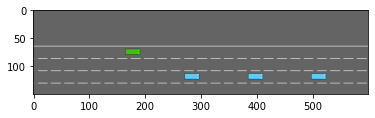

[[ 1.          0.9131481   0.          0.3125      0.        ]
 [ 1.          0.0956895   0.5        -0.02488427  0.        ]
 [ 1.          0.19914605  0.5        -0.04949645  0.        ]
 [ 1.          0.30264887  0.5        -0.04383641  0.        ]
 [ 1.          0.41845107  0.75       -0.02553821  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.8222222222222223
Nuevo estado:


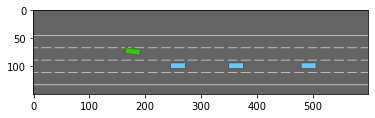

[[ 1.          1.          0.20821731  0.31063917  0.03405233]
 [ 1.          0.07289577  0.2917827  -0.09802343 -0.03405233]
 [ 1.          0.16811273  0.2917827  -0.10221382 -0.03405233]
 [ 1.          0.28571475  0.2917827  -0.04504133 -0.03405233]
 [ 1.          0.39580166  0.5417827  -0.089611   -0.03405233]]

Acción: LANE_RIGHT -> recommpensa: 0.17777777777777773
Nuevo estado:


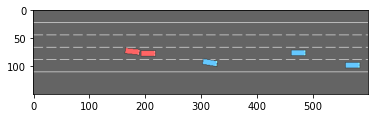

[[ 1.          1.          0.46992692  0.31064758  0.0339754 ]
 [ 1.          0.02536564  0.04085431 -0.14355488 -0.03690634]
 [ 1.          0.1255856   0.23837358 -0.11139589 -0.00166251]
 [ 1.          0.26957136  0.03007307 -0.04775482 -0.0339754 ]
 [ 1.          0.3581624   0.28007308 -0.10712173 -0.0339754 ]]
Episodio terminado después de 2 pasos y la recompensa fue 1.0


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [9]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (self.n_inputs,)))  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

Luego tenemos que crear el agente:

In [10]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [19]:
# Definición de los hiperparámetros

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 1500   # Número de episodios
# BURN_IN = 100        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 4000   # Número de episodios
# BURN_IN = 1000        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 500       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.8          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 64      # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 100      # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [20]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-10-7b9067ae957f>:137: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 204 Mean Rewards 20.32 Epsilon 0.13000034453500542		

C:\Users\mario\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mario\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 907 Mean Rewards 21.93 Epsilon 0.01		2118606165716			

KeyboardInterrupt: 

In [15]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

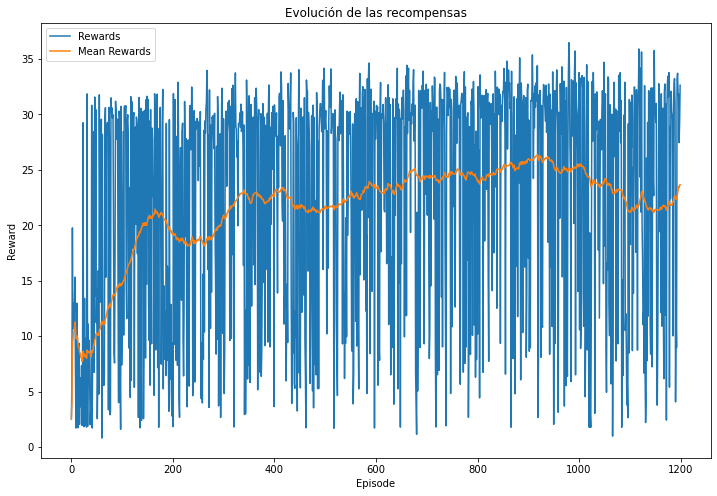

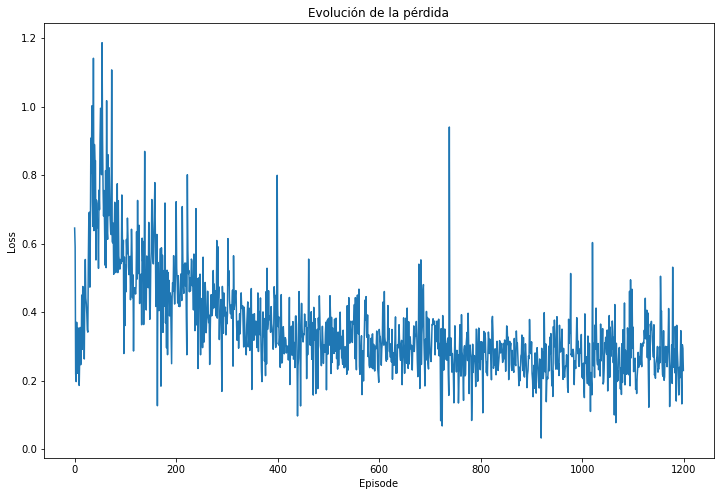

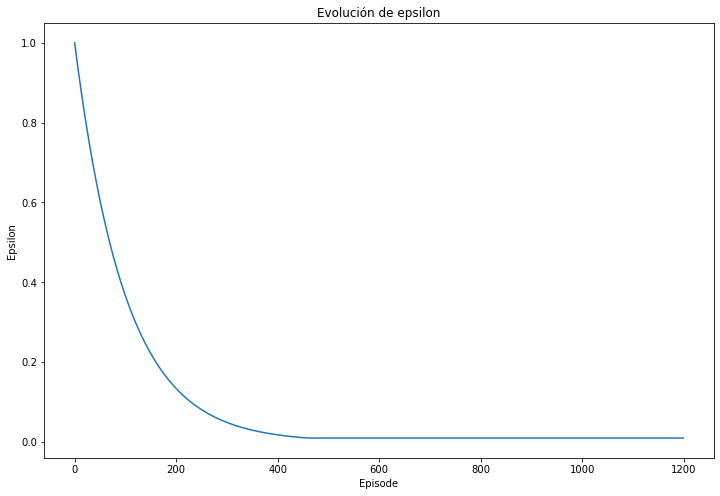

In [16]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

Obs inicial:


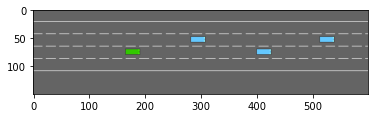

[[ 1.          0.8779924   0.5         0.3125      0.        ]
 [ 1.          0.10609721 -0.25       -0.0248319   0.        ]
 [ 1.          0.21344733  0.         -0.04413789  0.        ]
 [ 1.          0.31576502 -0.25       -0.01801774  0.        ]
 [ 1.          0.41525394  0.         -0.04436005  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


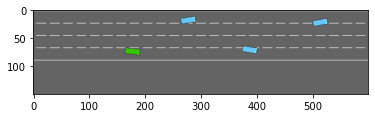

[[ 1.          1.          0.7082173   0.31063917  0.03405233]
 [ 1.          0.09041832 -0.64236903 -0.05218756 -0.07315363]
 [ 1.          0.19008802 -0.02319541 -0.06729183  0.00517793]
 [ 1.          0.30556837 -0.5870816  -0.03627827 -0.08260736]
 [ 1.          0.39800254 -0.20821731 -0.04589728 -0.03405233]]

Acción: SLOWER -> recommpensa: 0.7561184312834853
Nuevo estado:


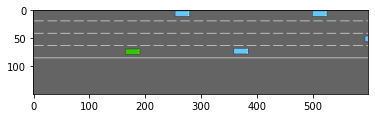

[[ 1.0000000e+00  1.0000000e+00  7.6070893e-01  2.6068038e-01
   2.6056790e-04]
 [ 1.0000000e+00  8.0155931e-02 -7.7079540e-01 -9.5229279e-03
  -3.1680679e-03]
 [ 1.0000000e+00  1.7583434e-01 -3.7274466e-04 -1.5693465e-02
   2.6628862e-03]
 [ 1.0000000e+00  3.0393466e-01 -7.6847297e-01  1.7062960e-02
  -8.8516790e-03]
 [ 1.0000000e+00  3.8970140e-01 -2.6070890e-01 -6.2246369e-03
  -2.6056790e-04]]

Acción: SLOWER -> recommpensa: 0.7372270384978186
Nuevo estado:


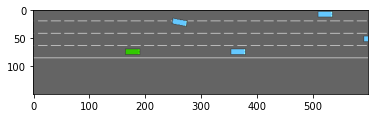

[[ 1.0000000e+00  1.0000000e+00  7.5200045e-01  2.5182092e-01
  -1.4656790e-03]
 [ 1.0000000e+00  7.6458655e-02 -5.9348506e-01 -6.5765809e-03
   4.8231203e-02]
 [ 1.0000000e+00  1.7157596e-01  1.3351323e-03 -7.3434627e-03
  -3.3143745e-04]
 [ 1.0000000e+00  3.1293967e-01 -7.5831503e-01  2.5957931e-02
   3.8850983e-03]
 [ 1.0000000e+00  3.8816223e-01 -2.5200045e-01 -3.0706476e-03
   1.4656790e-03]]

Acción: SLOWER -> recommpensa: 0.7339987217350469
Nuevo estado:


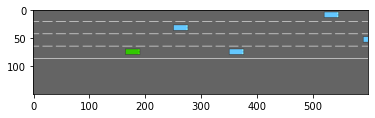

[[ 1.0000000e+00  1.0000000e+00  7.4953407e-01  2.5031188e-01
  -5.0058130e-05]
 [ 1.0000000e+00  7.7731170e-02 -4.8812529e-01  1.0360774e-02
   5.3192982e-03]
 [ 1.0000000e+00  1.6903284e-01  5.4068223e-05 -5.6121005e-03
  -1.3326452e-04]
 [ 1.0000000e+00  3.2361057e-01 -7.4919730e-01  2.6974928e-02
   5.1575009e-04]
 [ 1.0000000e+00  3.8668877e-01 -2.4953410e-01 -4.5215711e-03
   5.0058130e-05]]

Acción: FASTER -> recommpensa: 0.8439952757658243
Nuevo estado:


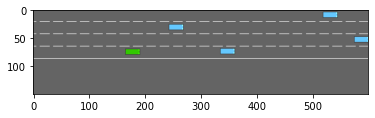

[[ 1.0000000e+00  1.0000000e+00  7.4990106e-01  3.0187279e-01
   7.2108378e-05]
 [ 1.0000000e+00  7.0746697e-02 -4.9500063e-01 -3.4595221e-02
  -2.4245013e-03]
 [ 1.0000000e+00  1.5436766e-01 -7.0221315e-05 -5.6727011e-02
   9.2489281e-06]
 [ 1.0000000e+00  3.2177132e-01 -7.4957341e-01 -2.5283244e-02
  -1.9168318e-04]
 [ 1.0000000e+00  3.7206200e-01 -2.4990107e-01 -5.7406303e-02
  -7.2108378e-05]]

Acción: LANE_RIGHT -> recommpensa: 0.8627923926991027
Nuevo estado:


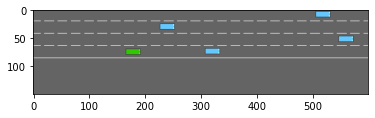

[[ 1.0000000e+00  1.0000000e+00  7.5002813e-01  3.1068394e-01
   1.1626428e-06]
 [ 1.0000000e+00  5.5504635e-02 -5.0055873e-01 -3.9906334e-02
  -2.9368303e-04]
 [ 1.0000000e+00  1.2962867e-01 -1.2415365e-05 -6.5072834e-02
   9.5249361e-06]
 [ 1.0000000e+00  3.0939269e-01 -7.5004190e-01 -3.4775186e-02
  -2.6318916e-05]
 [ 1.0000000e+00  3.4701303e-01 -2.5002813e-01 -6.5763764e-02
  -1.1626428e-06]]

Acción: LANE_RIGHT -> recommpensa: 0.8660045988278916
Nuevo estado:


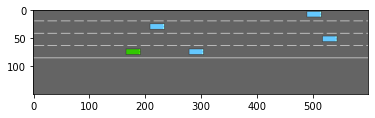

[[ 1.0000000e+00  1.0000000e+00  7.5000548e-01  3.1218967e-01
  -4.0441541e-06]
 [ 1.0000000e+00  3.9534617e-02 -5.0026351e-01 -3.9735790e-02
   1.2157821e-04]
 [ 1.0000000e+00  1.0331382e-01  3.0060532e-06 -6.6157930e-02
   4.0007134e-07]
 [ 1.0000000e+00  2.9500180e-01 -7.5002241e-01 -3.6886442e-02
   9.8960418e-06]
 [ 1.0000000e+00  3.2049888e-01 -2.5000545e-01 -6.6412874e-02
   4.0441541e-06]]

Acción: LANE_RIGHT -> recommpensa: 0.8665535270624957
Nuevo estado:


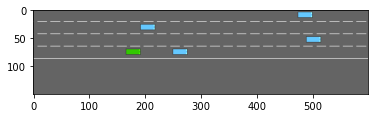

[[ 1.0000000e+00  1.0000000e+00  7.4999845e-01  3.1244695e-01
  -5.1085934e-08]
 [ 1.0000000e+00  2.3724522e-02 -4.9997419e-01 -3.9340194e-02
   1.6277645e-05]
 [ 1.0000000e+00  7.6867357e-02  1.0055619e-06 -6.5986454e-02
  -5.4574230e-07]
 [ 1.0000000e+00  2.8008407e-01 -7.4999791e-01 -3.7670758e-02
   1.4029932e-06]
 [ 1.0000000e+00  2.9403746e-01 -2.4999844e-01 -6.5787598e-02
   5.1085934e-08]]

Acción: SLOWER -> recommpensa: 0.7560990970562623
Nuevo estado:


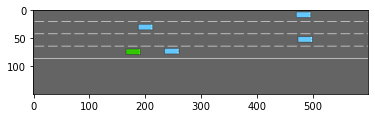

[[ 1.00000000e+00  1.00000000e+00  7.49999642e-01  2.60671467e-01
   2.15357289e-07]
 [ 1.00000000e+00  2.05715206e-02 -4.99986202e-01  1.25261564e-02
  -6.04080969e-06]
 [ 1.00000000e+00  6.31099045e-02 -9.15883973e-08 -1.37542505e-02
  -5.42843210e-08]
 [ 1.00000000e+00  2.77480185e-01 -7.49998808e-01  1.36419181e-02
  -4.99383077e-07]
 [ 1.00000000e+00  2.80428916e-01 -2.49999672e-01 -1.32062566e-02
  -2.15357289e-07]]

Acción: LANE_RIGHT -> recommpensa: 0.7372237345058607
Nuevo estado:


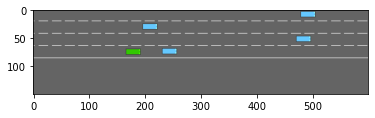

[[ 1.0000000e+00  1.0000000e+00  7.5000006e-01  2.5182363e-01
   1.1586648e-08]
 [ 1.0000000e+00  2.7694391e-02 -5.0000113e-01  2.1159790e-02
  -9.0637633e-07]
 [ 1.0000000e+00  5.9841096e-02 -4.4250150e-08 -4.4352114e-03
   2.0750106e-08]
 [ 1.0000000e+00  2.7742511e-01 -2.5000006e-01 -3.6631320e-03
  -1.1586648e-08]
 [ 1.0000000e+00  2.8500313e-01 -7.5000006e-01  2.2073770e-02
  -8.3869480e-08]]

Acción: SLOWER -> recommpensa: 0.733998157121694
Nuevo estado:


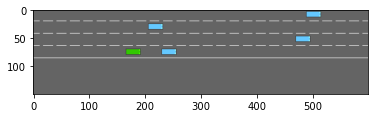

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  2.5031164e-01
  -9.8966195e-09]
 [ 1.0000000e+00  3.6457974e-02 -5.0000072e-01  2.2292079e-02
   2.9631477e-07]
 [ 1.0000000e+00  5.8521297e-02  3.7840513e-09 -2.4552671e-03
   2.8791085e-09]
 [ 1.0000000e+00  2.7643913e-01 -2.5000003e-01 -1.5659515e-03
   9.8966186e-09]
 [ 1.0000000e+00  2.9412663e-01 -7.5000006e-01  2.3201499e-02
   2.3564597e-08]]

Acción: SLOWER -> recommpensa: 0.7334469438968637
Nuevo estado:


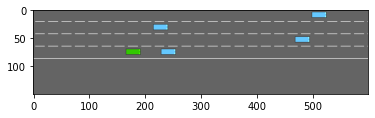

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  2.5005326e-01
  -7.7933959e-10]
 [ 1.0000000e+00  4.5351814e-02 -4.9999994e-01  2.2079866e-02
   4.9764388e-08]
 [ 1.0000000e+00  5.7686832e-02  2.2313913e-09 -1.7452544e-03
  -9.3433472e-10]
 [ 1.0000000e+00  2.7596956e-01 -2.5000000e-01 -8.1861543e-04
   7.7933970e-10]
 [ 1.0000000e+00  3.0340138e-01 -7.5000000e-01  2.3095571e-02
   4.6250785e-09]]

Acción: SLOWER -> recommpensa: 0.73335274804197
Nuevo estado:


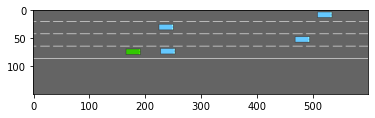

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  2.5000909e-01
   4.6120374e-10]
 [ 1.0000000e+00  5.4098323e-02 -4.9999997e-01  2.1602154e-02
  -1.4423331e-08]
 [ 1.0000000e+00  5.7080198e-02 -1.3331802e-10 -1.2729868e-03
  -1.6083257e-10]
 [ 1.0000000e+00  2.7573168e-01 -2.5000000e-01 -3.6463319e-04
  -4.6120374e-10]
 [ 1.0000000e+00  3.1258416e-01 -7.5000000e-01  2.2786783e-02
  -1.1126753e-09]]

Acción: SLOWER -> recommpensa: 0.733336651078618
Nuevo estado:


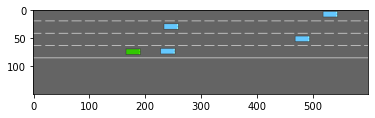

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  2.5000155e-01
   4.7664539e-11]
 [ 1.0000000e+00  5.6648731e-02 -1.1111290e-10 -8.6355803e-04
   4.1613601e-11]
 [ 1.0000000e+00  6.2638737e-02 -5.0000000e-01  2.1057656e-02
  -2.7094247e-09]
 [ 1.0000000e+00  2.7565420e-01 -2.5000000e-01 -1.0489446e-05
  -4.7664650e-11]
 [ 1.0000000e+00  3.2163572e-01 -7.5000000e-01  2.2446740e-02
  -2.5128577e-10]]

Acción: LANE_LEFT -> recommpensa: 0.7111116780747456
Nuevo estado:


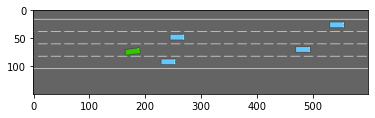

[[ 1.          1.          0.54126483  0.247799   -0.03310269]
 [ 1.          0.05782319  0.20873518  0.0017147   0.03310269]
 [ 1.          0.07240465 -0.2912648   0.02268944  0.03310269]
 [ 1.          0.27715576 -0.04126481  0.00248862  0.03310269]
 [ 1.          0.33199868 -0.54126483  0.02430295  0.03310269]]

Acción: LANE_LEFT -> recommpensa: 0.6888889857763035
Nuevo estado:


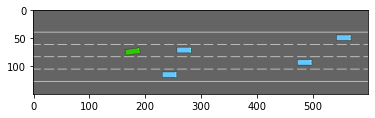

[[ 1.          1.          0.28034657  0.24769859 -0.03384419]
 [ 1.          0.05999828  0.46965343  0.00216612  0.03384419]
 [ 1.          0.08279483 -0.03034657  0.02220686  0.03384419]
 [ 1.          0.2796232   0.21965343  0.00284585  0.03384419]
 [ 1.          0.34307793 -0.28034657  0.02405554  0.03384419]]

Acción: LANE_LEFT -> recommpensa: 0.6666666832235859
Nuevo estado:


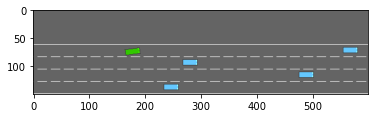

[[ 1.          1.          0.02820621  0.24790445 -0.03230146]
 [ 1.          0.06216022  0.7217938   0.00228863  0.03230146]
 [ 1.          0.09280092  0.22179379  0.02140984  0.03230146]
 [ 1.          0.28203797  0.4717938   0.00286495  0.03230146]
 [ 1.          0.35386822 -0.02820621  0.0234986   0.03230146]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888917182716
Nuevo estado:


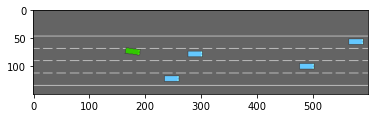

[[ 1.          1.          0.19630626  0.24768236  0.0339624 ]
 [ 1.          0.06331109  0.5536938   0.00281858 -0.0339624 ]
 [ 1.          0.10143096  0.05369375  0.0210355  -0.0339624 ]
 [ 1.          0.2833992   0.30369374  0.00328606 -0.0339624 ]
 [ 1.          0.36337876 -0.19630626  0.02336527 -0.0339624 ]]

Acción: LANE_LEFT -> recommpensa: 0.6666666671501749
Nuevo estado:


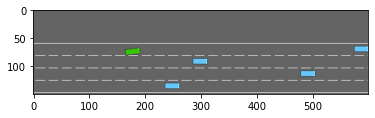

[[ 1.          1.          0.05063985  0.24808422 -0.03089042]
 [ 1.          0.06435292  0.69936013  0.00270609  0.03089042]
 [ 1.          0.10959315  0.19936015  0.02003428  0.03089042]
 [ 1.          0.2846072   0.44936016  0.00306175  0.03089042]
 [ 1.          0.3725176  -0.05063985  0.02260298  0.03089042]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888889715147
Nuevo estado:


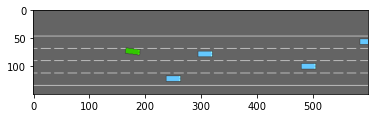

[[ 1.          1.          0.20049056  0.24808878  0.03085387]
 [ 1.          0.06553606  0.5495094   0.00297417 -0.03085387]
 [ 1.          0.11754411  0.04950943  0.01942958 -0.03085387]
 [ 1.          0.2859115   0.29950944  0.00321668 -0.03085387]
 [ 1.          0.38153994 -0.20049056  0.02223268 -0.03085387]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666807863
Nuevo estado:


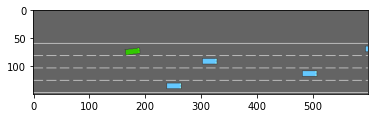

[[ 1.          1.          0.04966581  0.24807109 -0.03099572]
 [ 1.          0.06683502  0.7003342   0.00324928  0.03099572]
 [ 1.          0.12526484  0.20033419  0.0188484   0.03099572]
 [ 1.          0.2872863   0.4503342   0.0033784   0.03099572]
 [ 1.          0.39042467 -0.04966581  0.02187916  0.03099572]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888913017
Nuevo estado:


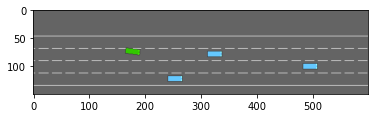

[[ 1.          1.          0.20028439  0.24807113  0.03099541]
 [ 1.          0.06823281  0.54971564  0.00349278 -0.03099541]
 [ 1.          0.13274506  0.04971561  0.01825288 -0.03099541]
 [ 1.          0.28871465  0.2997156   0.00350908 -0.03099541]
 [ 1.          0.3991584  -0.20028439  0.02150254 -0.03099541]]

Acción: LANE_LEFT -> recommpensa: 0.666666666667079
Nuevo estado:


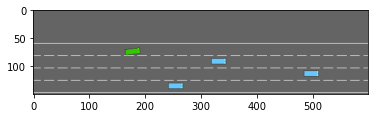

[[ 1.          1.          0.04970771  0.24807194 -0.03098889]
 [ 1.          0.06972516  0.7002923   0.00372272  0.03098889]
 [ 1.          0.13998762  0.20029229  0.01766204  0.03098889]
 [ 1.          0.29019263  0.4502923   0.00362735  0.03098889]
 [ 1.          0.4077401  -0.04970771  0.02111994  0.03098889]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888889593
Nuevo estado:


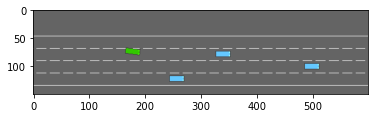

[[ 1.          1.          0.20029446  0.24807192  0.03098899]
 [ 1.          0.07130767  0.54970556  0.00394168 -0.03098899]
 [ 1.          0.14699559  0.04970554  0.01707959 -0.03098899]
 [ 1.          0.29171637  0.29970554  0.00373625 -0.03098899]
 [ 1.          0.41616818 -0.20029446  0.02073323 -0.03098899]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666786
Nuevo estado:


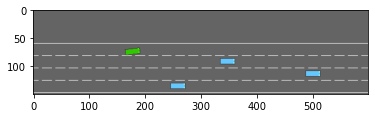

[[ 1.          1.          0.04970593  0.2480719  -0.03098929]
 [ 1.          0.07297569  0.7002941   0.00414969  0.03098929]
 [ 1.          0.15377231  0.20029408  0.01650679  0.03098929]
 [ 1.          0.29328197  0.45029408  0.00383616  0.03098929]
 [ 1.          0.42444074 -0.04970593  0.02034195  0.03098929]]

Acción: LANE_RIGHT -> recommpensa: 0.688888888888891
Nuevo estado:


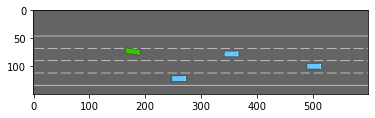

[[ 1.          1.          0.20029397  0.2480719   0.03098928]
 [ 1.          0.07472496  0.54970604  0.00434743 -0.03098928]
 [ 1.          0.16032201  0.04970602  0.01594562 -0.03098928]
 [ 1.          0.294886    0.299706    0.00392807 -0.03098928]
 [ 1.          0.432556   -0.20029397  0.01994645 -0.03098928]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


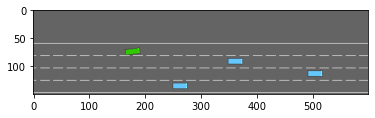

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.07655152  0.700294    0.00453558  0.03098927]
 [ 1.          0.16664973  0.20029399  0.01539807  0.03098927]
 [ 1.          0.29652545  0.450294    0.0040129   0.03098927]
 [ 1.          0.44051233 -0.049706    0.01954724  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


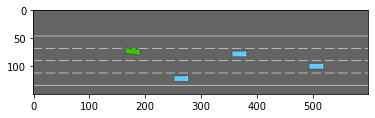

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.07845164  0.549706    0.00471473 -0.03098927]
 [ 1.          0.17276125  0.049706    0.01486599 -0.03098927]
 [ 1.          0.29819763  0.299706    0.00409147 -0.03098927]
 [ 1.          0.44830835 -0.200294    0.01914484 -0.03098927]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


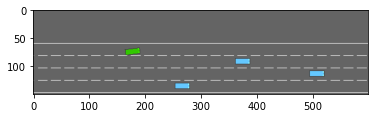

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.08042182  0.700294    0.00488539  0.03098927]
 [ 1.          0.1786631   0.200294    0.01435111  0.03098927]
 [ 1.          0.29990017  0.450294    0.00416447  0.03098927]
 [ 1.          0.45594293 -0.049706    0.01873981  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


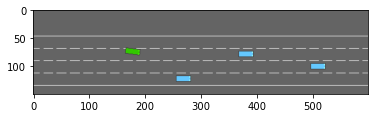

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.08245876  0.549706    0.00504805 -0.03098927]
 [ 1.          0.18436244  0.049706    0.013855   -0.03098927]
 [ 1.          0.30163097  0.299706    0.00423255 -0.03098927]
 [ 1.          0.4634151  -0.200294    0.01833276 -0.03098927]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


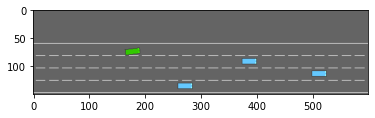

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.08455933  0.700294    0.00520312  0.03098927]
 [ 1.          0.18986708  0.200294    0.01337907  0.03098927]
 [ 1.          0.30338818  0.450294    0.00429624  0.03098927]
 [ 1.          0.47072414 -0.049706    0.01792434  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


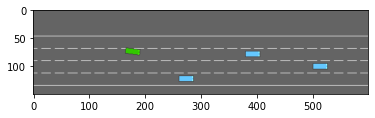

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.08672057  0.549706    0.00535105 -0.03098927]
 [ 1.          0.19518527  0.049706    0.01292451 -0.03098927]
 [ 1.          0.3051699   0.299706    0.00435428 -0.03098927]
 [ 1.          0.4778697  -0.200294    0.01751521 -0.03098927]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


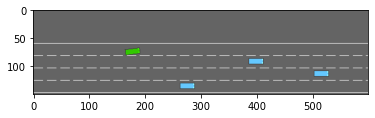

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.08893981  0.700294    0.00549291  0.03098927]
 [ 1.          0.20032582  0.200294    0.01249235  0.03098927]
 [ 1.          0.30697322  0.450294    0.00440287  0.03098927]
 [ 1.          0.48485154 -0.049706    0.01710607  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


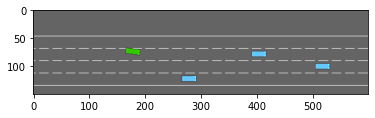

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.09121488  0.549706    0.00563011 -0.03098927]
 [ 1.          0.2052978   0.049706    0.01208339 -0.03098927]
 [ 1.          0.30879384  0.299706    0.00443997 -0.03098927]
 [ 1.          0.49166983 -0.200294    0.01669765 -0.03098927]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


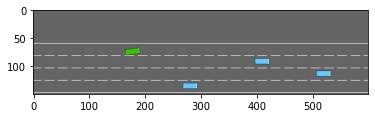

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.0935441   0.700294    0.00576349  0.03098927]
 [ 1.          0.21011062  0.200294    0.01169823  0.03098927]
 [ 1.          0.31062716  0.450294    0.00446583  0.03098927]
 [ 1.          0.49832502 -0.049706    0.01629068  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


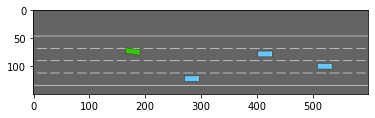

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.09592602  0.549706    0.00589341 -0.03098927]
 [ 1.          0.21477388  0.049706    0.01133725 -0.03098927]
 [ 1.          0.31246895  0.299706    0.00448181 -0.03098927]
 [ 1.          0.50481784 -0.200294    0.0158859  -0.03098927]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


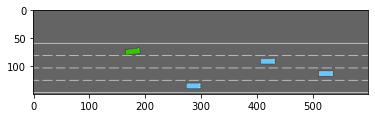

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.09835926  0.700294    0.00601993  0.03098927]
 [ 1.          0.21929729  0.200294    0.01100063  0.03098927]
 [ 1.          0.31431553  0.450294    0.00448954  0.03098927]
 [ 1.          0.5111492  -0.049706    0.01548407  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


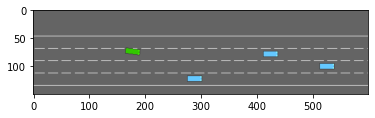

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.10084249  0.549706    0.00614303 -0.03098927]
 [ 1.          0.2236906   0.049706    0.01068839 -0.03098927]
 [ 1.          0.31616387  0.299706    0.00449047 -0.03098927]
 [ 1.          0.5173206  -0.200294    0.01508593 -0.03098927]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666666671
Nuevo estado:


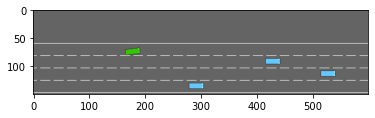

[[ 1.          1.          0.049706    0.2480719  -0.03098927]
 [ 1.          0.10337431  0.700294    0.0062627   0.03098927]
 [ 1.          0.22796355  0.200294    0.01040033  0.03098927]
 [ 1.          0.31801152  0.450294    0.0044858   0.03098927]
 [ 1.          0.52333343 -0.049706    0.01469222  0.03098927]]

Acción: LANE_RIGHT -> recommpensa: 0.6888888888888892
Nuevo estado:


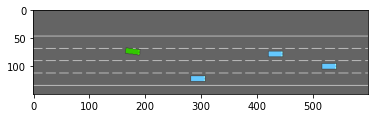

[[ 1.          1.          0.200294    0.2480719   0.03098927]
 [ 1.          0.10595337  0.549706    0.00637896 -0.03098927]
 [ 1.          0.23212573  0.049706    0.0101361  -0.03098927]
 [ 1.          0.3198564   0.299706    0.00447643 -0.03098927]
 [ 1.          0.52918977 -0.200294    0.01430367 -0.03098927]]
Episodio terminado después de 40 pasos y la recompensa fue 28.6274813347268


In [18]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))